# Electricity Demands

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix
from sklearn.semi_supervised import LabelPropagation

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [5]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

# EDA

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/Electricity.csv")
df

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,b'UP'
1,0.0000,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,b'UP'
2,0.0000,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,b'UP'
3,0.0000,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,b'UP'
4,0.0000,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,b'DOWN'
...,...,...,...,...,...,...,...,...,...
45307,0.9158,b'7',0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,b'DOWN'
45308,0.9158,b'7',0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,b'DOWN'
45309,0.9158,b'7',0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,b'DOWN'
45310,0.9158,b'7',0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,b'UP'


# Check For Nulls and Dupes

In [6]:
check_for_nulls_dupes(df)

The amount of Null Values: date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

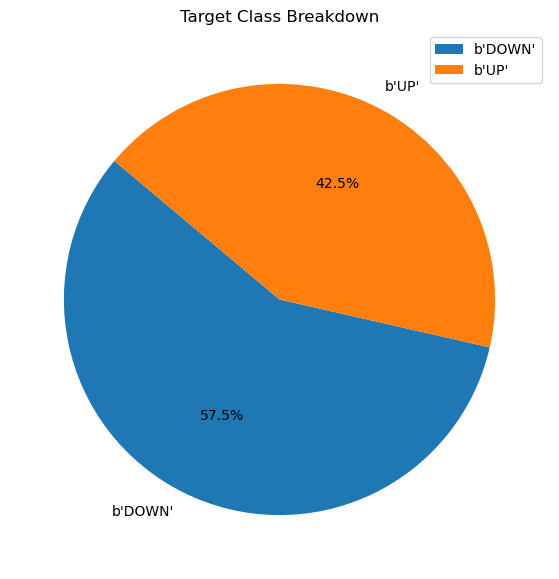

In [8]:
check_class_imbalance(df["class"])

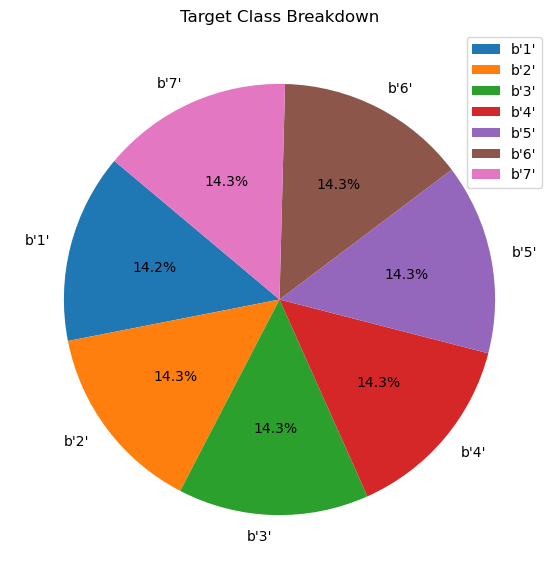

In [9]:
check_class_imbalance(df["day"])